# LUMI-C OSU mpi4py benchmarks

This notebook presents the results from running some of the [OSU mpi4py benchmarks v7.3](https://mvapich.cse.ohio-state.edu/benchmarks/) on LUMI-C. The raw results data in "./lumi_osu_results" was obtained by running the tests/benchmarks on LUMI as described in the "./README.md" file.

The OSU benchmarks used are:
- OMB Python MPI Allgather, 3 processes, single and multi node (3 nodes, 1 process each)
- OSU OMB-Py MPI Bandwidth, 2 processes, single and multi node (2 nodes, 1 process each)
- OMB Python MPI Latency, 2 processes, single and multi node (2 nodes, 1 process each)

The test methods used are:
- **cotainr-hybrid-mpich3**: A cotainr singularity container built from the "./containers/py310_mpich3_pip_mpi4py.yml" conda environment, using the MPICH v3 provided with the conda environment.
- **cotainr-hybrid-mpich4**: A cotainr singularity container built from the "./containers/py310_mpich4_pip_mpi4py.yml" conda environment, using the MPICH v4 provided with the conda environment.
- **cotainr-bind-mpich3**: A cotainr singularity container built from the "./containers/py310_mpich3_pip_mpi4py.yml" conda environment, bind mounting the host MPICH (cray-mpich/8.1.27) in the container at runtime.
- **cotainr-bind-mpich4**: A cotainr singularity container built from the "./containers/py310_mpich4_pip_mpi4py.yml" conda environment, bind mounting the host MPICH (cray-mpich/8.1.27) in the container at runtime.
- **cray-python**: The cray-python/3.10.10 module on LUMI.
- **lumi-sif**: The official LUMI mpi4py singularity container (lumi-mpi4py-rocm-5.4.5-python-3.10-mpi4py-3.1.4.sif) which also works by bind mounting cray-mpich/8.1.27 during runtime.

For more details about the hybrid vs bind mounting approach to apptainer/singularity containers, see https://apptainer.org/docs/user/latest/mpi.html#apptainer-and-mpi-applications.

This notebook was run using the "./py312_jupyter.yml" conda environment which was created from the package specification "jupyterlab pandas python=3.12 seaborn".

In [1]:
from pathlib import Path
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
# Test setup specification
osu_results_folder = Path("./lumi_osu_results/")
tests = {
    "allgather": {"processes": 3, "metric": "Latency (us)"},
    "bw": {"processes": 2, "metric": "Bandwidth (MB/s)"},
    "latency": {"processes": 2, "metric": "Latency (us)"},
}
test_methods = [
    "cotainr-hybrid-mpich3",
    "cotainr-hybrid-mpich4",
    "cotainr-bind-mpich3",
    "cotainr-bind-mpich4",
    "cray-python",
    "lumi-sif",
]

In [3]:
# Helper functions
def extract_nodes(*, file_name: Path) -> str:
    """
    Determine if `file_name` contains results for single or multi node(s).

    Returns
    -------
    nodes : str
        The nodes used, i.e. "single" or "multi".
    """
    if "-single" in file_name:
        nodes = "single"
    elif "-multi" in file_name:
        nodes = "multi"
    else:
        raise ValueError(f"file_name= does not contain 'single' or 'multi'")

    return nodes


def extract_test_method(*, file_name: Path) -> str:
    """
    Determine the test method used to obtain results in `file_name`.

    Returns
    -------
    test_method : str
        One of the test methods, e.g. cotainr-hybrid-mpich3
    """
    file_name_parts = file_name.split("-")
    test_method = "-".join(
        # fmt: off
        file_name_parts[1:3] # name of module/container, e.g. cotainr-bind or cray-python
        + (
            [file_name_parts[7]]  # mpich3/mpich4 for cotainr containers
            if "cotainr" in file_name else []
          )
        # fmt: on
    )

    return test_method


def read_osu_results_file(*, file_path: Path) -> pd.DataFrame:
    """
    Load the actual test/benchmark results from results file.

    Returns
    -------
    df_osu_results : pd.DataFrame
        A long-form pandas dataframe containing the results.

    Notes
    -----
    Assumes that the results file is similar to:

    # OMB Python MPI Allgather Test
    # Size (B)      Latency (us)
    1                       6.81
    2                       6.79
    4                       6.82
    ...

    I.e., it is a fixed with text file, with:
    - two header rows prefixed by "# ": 1. The name of the test, 2. The column names and units
    - a 16 character first column containing integers
    - a 12 character second colum containing decimal numbers
    """
    with file_path.open(mode="r") as f:
        test_name = f.readline().removeprefix("# ").strip()
        column_names = re.split(r"\s{2,}", f.readline().removeprefix("# ").strip())
    osu_colspecs = [(0, 16), (16, 29)]
    osu_dtypes = {column_names[0]: "int64", column_names[1]: "float64"}
    df_osu_results = pd.read_fwf(
        file_path,
        colspecs=osu_colspecs,
        header=1,
        names=column_names,
        dtype=osu_dtypes,
    )
    df_osu_results["Nodes"] = extract_nodes(file_name=file_path.name)
    df_osu_results["Test method"] = extract_test_method(file_name=file_path.name)
    df_osu_results.attrs["name"] = test_name

    return df_osu_results


def show_osu_pivot_table(
    *, df: pd.DataFrame, metric: str, test_methods: list[str]
) -> pd.DataFrame:
    """
    Create a pivot table for the OSU results dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a pivot table for.
    metric : str
        The metric used in the OSU benchmark.
    test_methods : list of str
        The test_methods in the OSU results dataframe.

    Returns
    -------
    df_pivot: pd.DataFrame
        The pivot table.
    """

    df_pivot = (
        df.pivot(index="Size (B)", columns=["Test method", "Nodes"], values=[metric])
        .reindex(columns=test_methods, level="Test method")
        .reindex(columns=["single", "multi"], level="Nodes")
    )
    return df_pivot


def barplot_osu_results(
    *, df: pd.DataFrame, metric: str, processes: int, test_methods: list[str]
) -> mpl.figure.Figure:
    """
    Create a barplot of OSU results dataframe.

    Create a plot of `metric` vs message size with `test_methods` overlayed and
    single/multi node facetted.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a barplot for.
    metric : str
        The metric used in the OSU benchmark.
    processes : int
        The number of processes used in the OSU benchmark
    test_methods : list[str]
        The test_methods in the OSU results dataframe.

    Returns
    -------
    mpl.figure.Figure
        The barplot figure handle.
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 15))
    for ax, nodes in zip(axes, ["single", "multi"]):
        sns.barplot(
            df.loc[df["Nodes"] == nodes],
            x="Size (B)",
            y=metric,
            hue="Test method",
            hue_order=test_methods,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=45)
        ax.set_yscale("log")
        ax.legend(title="Multiple nodes" if nodes == "multi" else "Single node")

    fig.suptitle(f"LUMI-C OSU {df.attrs['name']} results - {processes} processes")
    fig.tight_layout()

    return fig

In [4]:
# Load the actual data
osu_result_dfs = {
    test_name: pd.concat(
        [
            read_osu_results_file(file_path=file_path)
            for file_path in osu_results_folder.glob(f"*-{test_name}-*")
        ]
    )
    for test_name in tests
}

## Allgather test results

In [5]:
print(f"LUMI-C OSU {osu_result_dfs["allgather"].attrs['name']} results - {tests['allgather']['processes']} processes")
show_osu_pivot_table(
    df=osu_result_dfs["allgather"],
    metric=tests["allgather"]["metric"],
    test_methods=test_methods,
)

LUMI-C OSU OMB Python MPI Allgather Test results - 3 processes


Latency (us)                                           \
Test method cotainr-hybrid-mpich3           cotainr-hybrid-mpich4            
Nodes                      single     multi                single    multi   
Size (B)                                                                     
1                            0.84     98.05                  1.18    49.40   
2                            0.84     98.04                  1.18    49.36   
4                            0.83     98.04                  1.18    49.36   
8                            0.83     98.03                  1.18    49.20   
16                           0.80     98.11                  1.18    48.96   
32                           0.78     98.04                  1.18    49.21   
64                           0.73     98.05                  1.19    50.06   
128                          0.74    103.17                  1.20    49.76   
256                          0.78    134.96                  1.22    81.60   
512                          0.84    134.13                  1.25    79.94   
1024                         0.89    202.26                  1.34   106.52   
2048                         1.04    274.55                  1.44    97.46   
4096                         1.31    481.38                  1.64   100.47   
8192                         1.84    485.71                  1.91    99.35   
16384                        2.75    794.50                  3.74   108.44   
32768                        4.49    893.26                  5.20   146.46   
65536                        8.23   1457.94                  8.60   227.77   
131072                      16.00   3162.16                 17.66   310.82   
262144                      29.63   5779.80                 31.72   466.64   
524288                      62.83  11075.93                 58.21   727.61   
1048576                    133.22  22115.32                113.39  1247.21   

                                                                     \
Test method cotainr-bind-mpich3         cotainr-bind-mpich4           
Nodes                    single   multi              single   multi   
Size (B)                                                              
1                          1.40    6.84                1.31    6.79   
2                          1.40    6.82                1.32    6.80   
4                          1.35    6.85                1.31    6.81   
8                          1.35    6.81                1.32    6.77   
16                         1.33    6.85                1.32    6.81   
32                         1.32    6.85                1.32    6.76   
64                         1.32    6.80                1.32    6.72   
128                        1.33    7.49                1.32    7.35   
256                        1.33    9.19                1.35    9.11   
512                        1.35    9.55                1.41    9.41   
1024                       1.41   10.02                1.44    9.90   
2048                       1.47   10.30                1.53   10.25   
4096                       1.62   10.71                1.68   10.60   
8192                       4.18   12.10                4.23   12.12   
16384                      5.18   14.90                5.20   14.11   
32768                      7.19   23.68                7.13   23.45   
65536                     12.04   31.26               11.94   31.05   
131072                    20.71   48.53               21.84   48.71   
262144                    34.68   82.12               43.40   78.15   
524288                    56.12  147.42               63.83  137.28   
1048576                  102.73  173.85              109.44  168.84   

                                                  
Test method cray-python         lumi-sif          
Nodes            single   multi   single   multi  
Size (B)                                          
1                  2.36    6.86     2.19    6.83  
2                  2.29    6.84     2.2

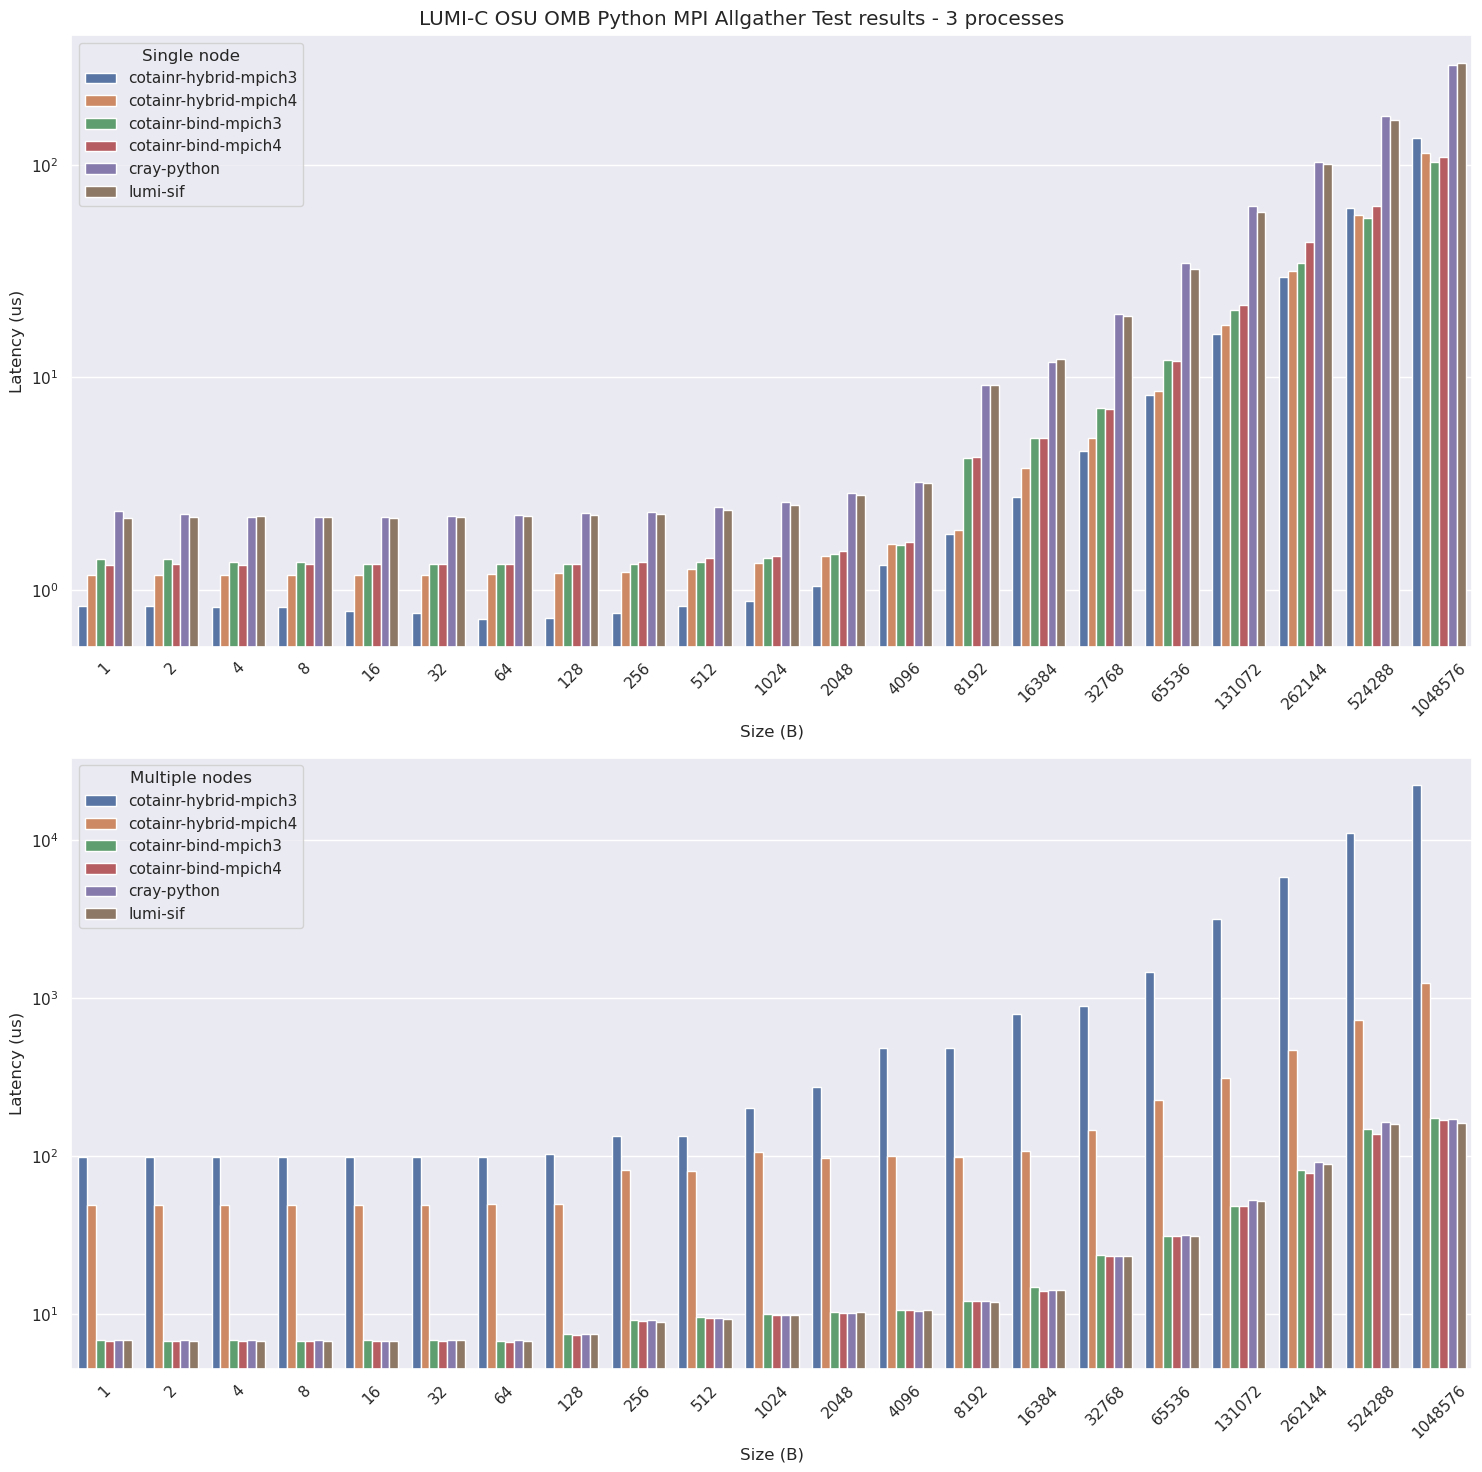

In [6]:
fig_allgather = barplot_osu_results(
    df=osu_result_dfs["allgather"],
    metric=tests["allgather"]["metric"],
    processes=tests["allgather"]["processes"],
    test_methods=test_methods,
)

## Bandwidth test results

In [7]:
print(f"LUMI-C OSU {osu_result_dfs["bw"].attrs['name']} results - {tests['bw']['processes']} processes")
show_osu_pivot_table(
    df=osu_result_dfs["bw"], metric=tests["bw"]["metric"], test_methods=test_methods
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes


Bandwidth (MB/s)                                         \
Test method cotainr-hybrid-mpich3         cotainr-hybrid-mpich4            
Nodes                      single   multi                single    multi   
Size (B)                                                                   
1                            2.53    0.19                  1.83     0.16   
2                            5.06    0.40                  3.66     0.33   
4                           10.14    0.80                  7.32     0.66   
8                           20.24    1.55                 14.65     1.32   
16                          40.11    3.01                 29.29     2.64   
32                          81.17    6.51                 58.45     5.11   
64                         161.57   11.47                116.18     9.92   
128                        319.15   20.07                230.47    19.44   
256                        596.21   35.74                449.77    22.08   
512                       1137.74   54.53                859.29    44.06   
1024                      2345.77   72.51               1726.15    63.93   
2048                      4095.93   95.65               3288.27   133.48   
4096                      6687.62  106.43               5906.92   256.18   
8192                     10827.83  108.09              10106.47   487.73   
16384                    17601.57  113.89              11308.24   862.39   
32768                    20030.57  116.36              15383.31  1439.74   
65536                    13511.32  117.37              19524.45  2088.33   
131072                   15021.72  117.40              22430.83  3222.56   
262144                   17526.17  117.89              24071.82  4086.21   
524288                   18069.45  118.09              24792.70  4851.19   
1048576                  18786.96  117.41              25585.26  5443.49   
2097152                  18221.08  118.22              26266.85  5646.57   
4194304                  17856.92  118.27              25916.18  5711.67   

                                                                         \
Test method cotainr-bind-mpich3           cotainr-bind-mpich4             
Nodes                    single     multi              single     multi   
Size (B)                                                                  
1                          2.23      1.28                2.42      1.19   
2                          4.43      2.70                4.85      2.62   
4                          9.41      5.37                9.79      5.20   
8                         19.21     10.81               20.18     10.40   
16                        36.89     21.61               39.20     20.88   
32                        72.49     43.18               79.05     41.51   
64                       148.71     86.63              158.33     83.82   
128                      306.79    172.67              311.93    167.26   
256                      602.46    308.93              592.59    309.28   
512                     1163.50    647.86             1171.23    646.33   
1024                    2250.80   1294.58             2174.92   1290.18   
2048                    4142.72   2572.21             4080.74   2566.46   
4096                    7108.38   5075.62             7085.99   5054.34   
8192                    4479.77  10220.15             4409.55  10112.71   
16384                   6934.30  19278.14             6897.52  19434.70   
32768                   9697.63  20842.48             9536.92  20927.71   
65536                  11852.30  22180.99            11664.15  22227.83   
131072                 13282.34  23182.33            13402.36  23206.04   
262144                 13989.52  23630.32            13397.45  23653.21   
524288                 14619.84  23843.55            14265.03  23855.83   
1048576                15277.55  23945.14            14912.87  23959.27   
2097152                16023.23  23966.70            15699.27  24011.75   
4194304       

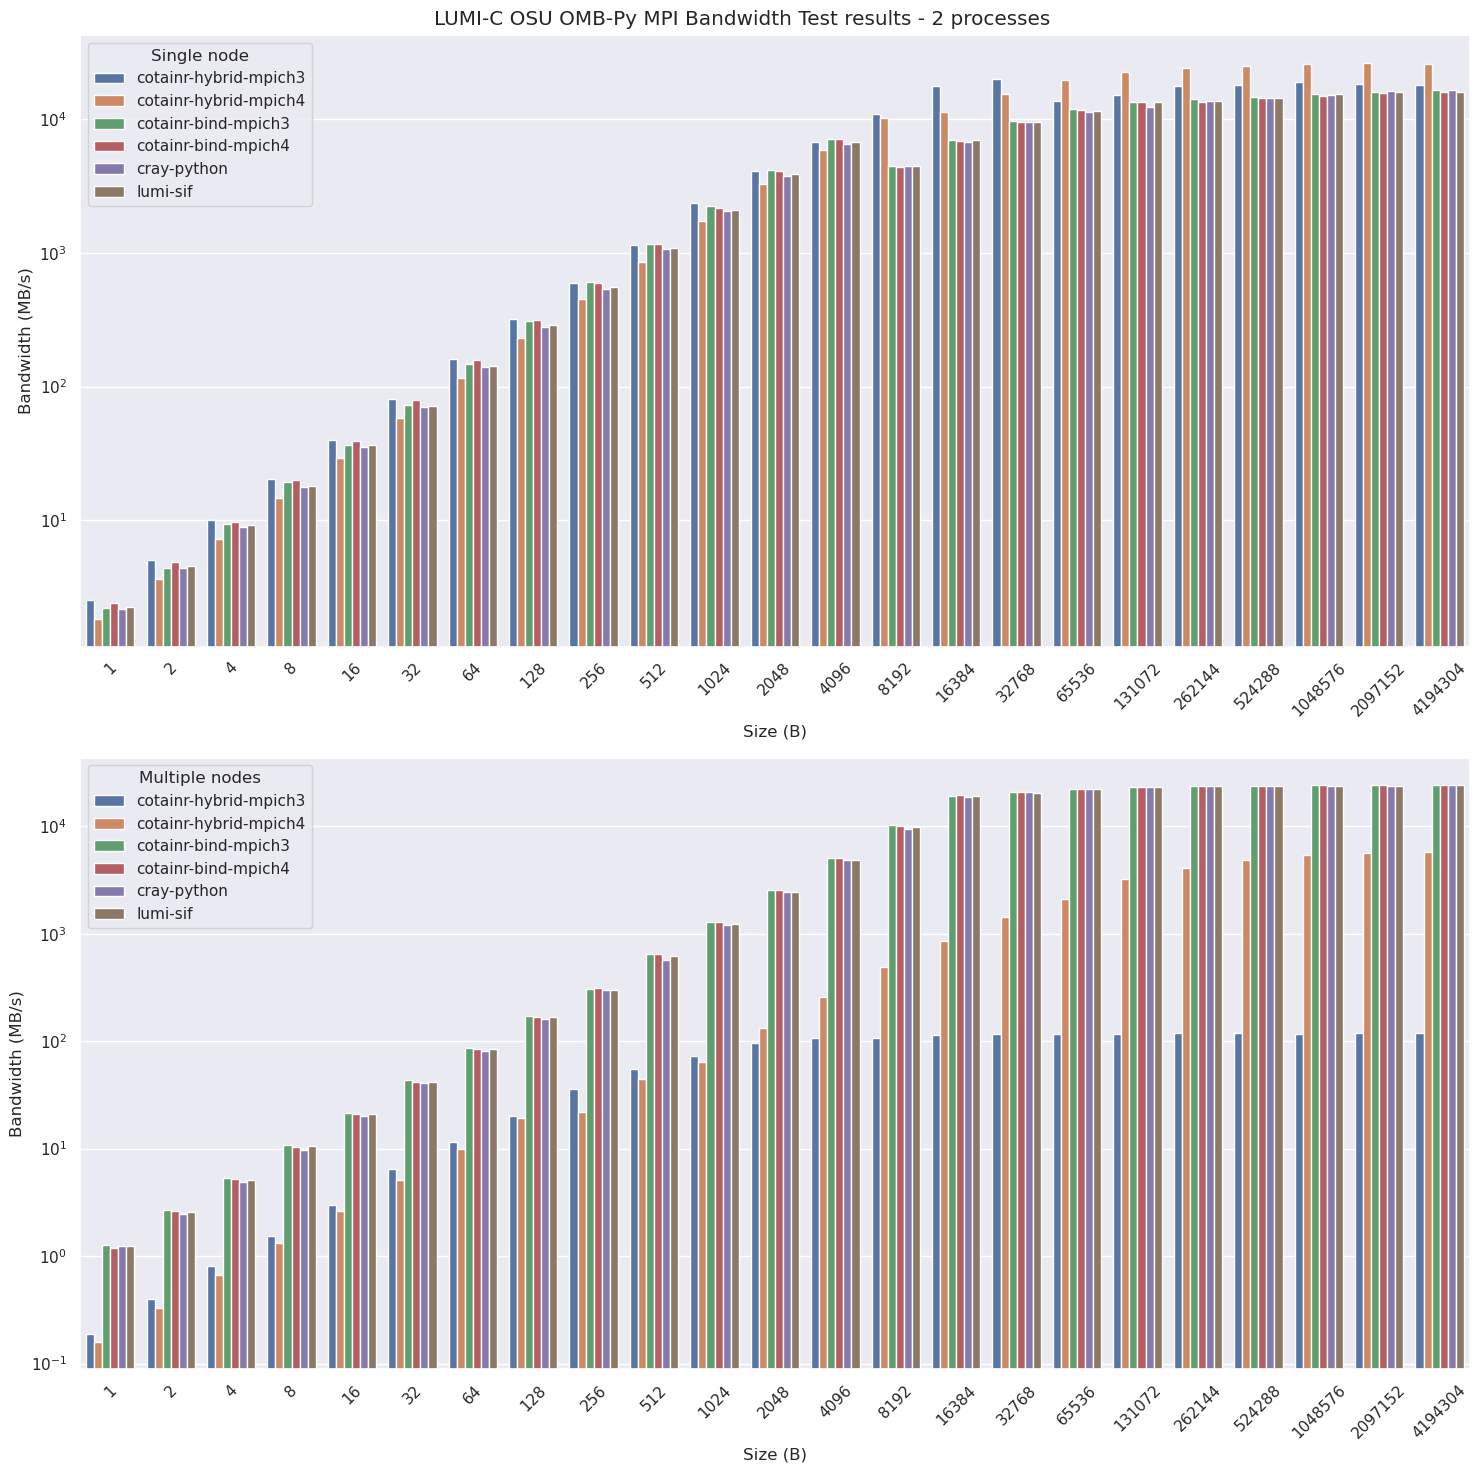

In [8]:
fig_bandwidth = barplot_osu_results(
    df=osu_result_dfs["bw"],
    metric=tests["bw"]["metric"],
    processes=tests["bw"]["processes"],
    test_methods=test_methods,
)

## Latency test results

In [9]:
print(f"LUMI-C OSU {osu_result_dfs["latency"].attrs['name']} results - {tests['latency']['processes']} processes")
show_osu_pivot_table(
    df=osu_result_dfs["latency"],
    metric=tests["latency"]["metric"],
    test_methods=test_methods,
)

LUMI-C OSU OMB Python MPI Latency Test results - 2 processes


Latency (us)                                          \
Test method cotainr-hybrid-mpich3           cotainr-hybrid-mpich4           
Nodes                      single     multi                single   multi   
Size (B)                                                                    
0                            0.45     43.06                  0.62   18.70   
1                            0.44     43.45                  0.64   18.74   
2                            0.44     42.95                  0.64   18.71   
4                            0.44     43.48                  0.64   18.70   
8                            0.43     42.72                  0.64   18.70   
16                           0.44     44.53                  0.64   18.71   
32                           0.50     49.00                  0.64   18.72   
64                           0.49     49.01                  0.64   18.92   
128                          0.51     49.01                  0.65   18.84   
256                          0.55     49.01                  0.66   24.70   
512                          0.56     55.03                  0.69   28.59   
1024                         0.59     98.02                  0.75   33.19   
2048                         0.73    126.10                  0.85   29.73   
4096                         0.93    208.25                  0.95   30.65   
8192                         1.28    219.64                  1.11   31.98   
16384                        1.96    303.53                  2.49   35.27   
32768                        3.17    447.73                  3.13   44.92   
65536                        3.66    747.47                  4.32   66.98   
131072                       5.17   1589.95                  8.04   85.65   
262144                      12.26   2560.83                 18.40  125.78   
524288                      23.47   4789.29                 27.62  192.74   
1048576                     48.29   9223.59                 49.36  313.96   
2097152                     99.93  18060.33                 94.69  546.49   
4194304                    204.04  35920.10                180.94  979.42   

                                                                     \
Test method cotainr-bind-mpich3         cotainr-bind-mpich4           
Nodes                    single   multi              single   multi   
Size (B)                                                              
0                          0.96    2.40                0.95    2.41   
1                          0.97    2.40                0.92    2.39   
2                          0.95    2.39                0.90    2.40   
4                          0.93    2.41                0.90    2.40   
8                          0.92    2.43                0.90    2.43   
16                         0.93    2.41                0.90    2.42   
32                         0.94    2.42                0.92    2.40   
64                         0.95    2.42                0.94    2.42   
128                        0.95    2.96                0.93    2.95   
256                        1.00    3.24                0.96    3.21   
512                        1.03    3.21                0.98    3.19   
1024                       1.07    3.20                1.07    3.19   
2048                       1.09    3.36                1.10    3.37   
4096                       1.19    3.68                1.19    3.62   
8192                       2.71    3.85                2.68    3.89   
16384                      3.35    4.27                3.36    4.36   
32768                      4.66    6.78                4.65    6.80   
65536                      6.82    8.17                6.64    8.19   
131072                    12.12   10.89               11.00   10.93   
262144                    24.13   16.43               20.03   16.40   
524288                    42.99   27.20               39.84   27.26   
1048576                   73.43   48.92               72.87   48.92   
2097152           

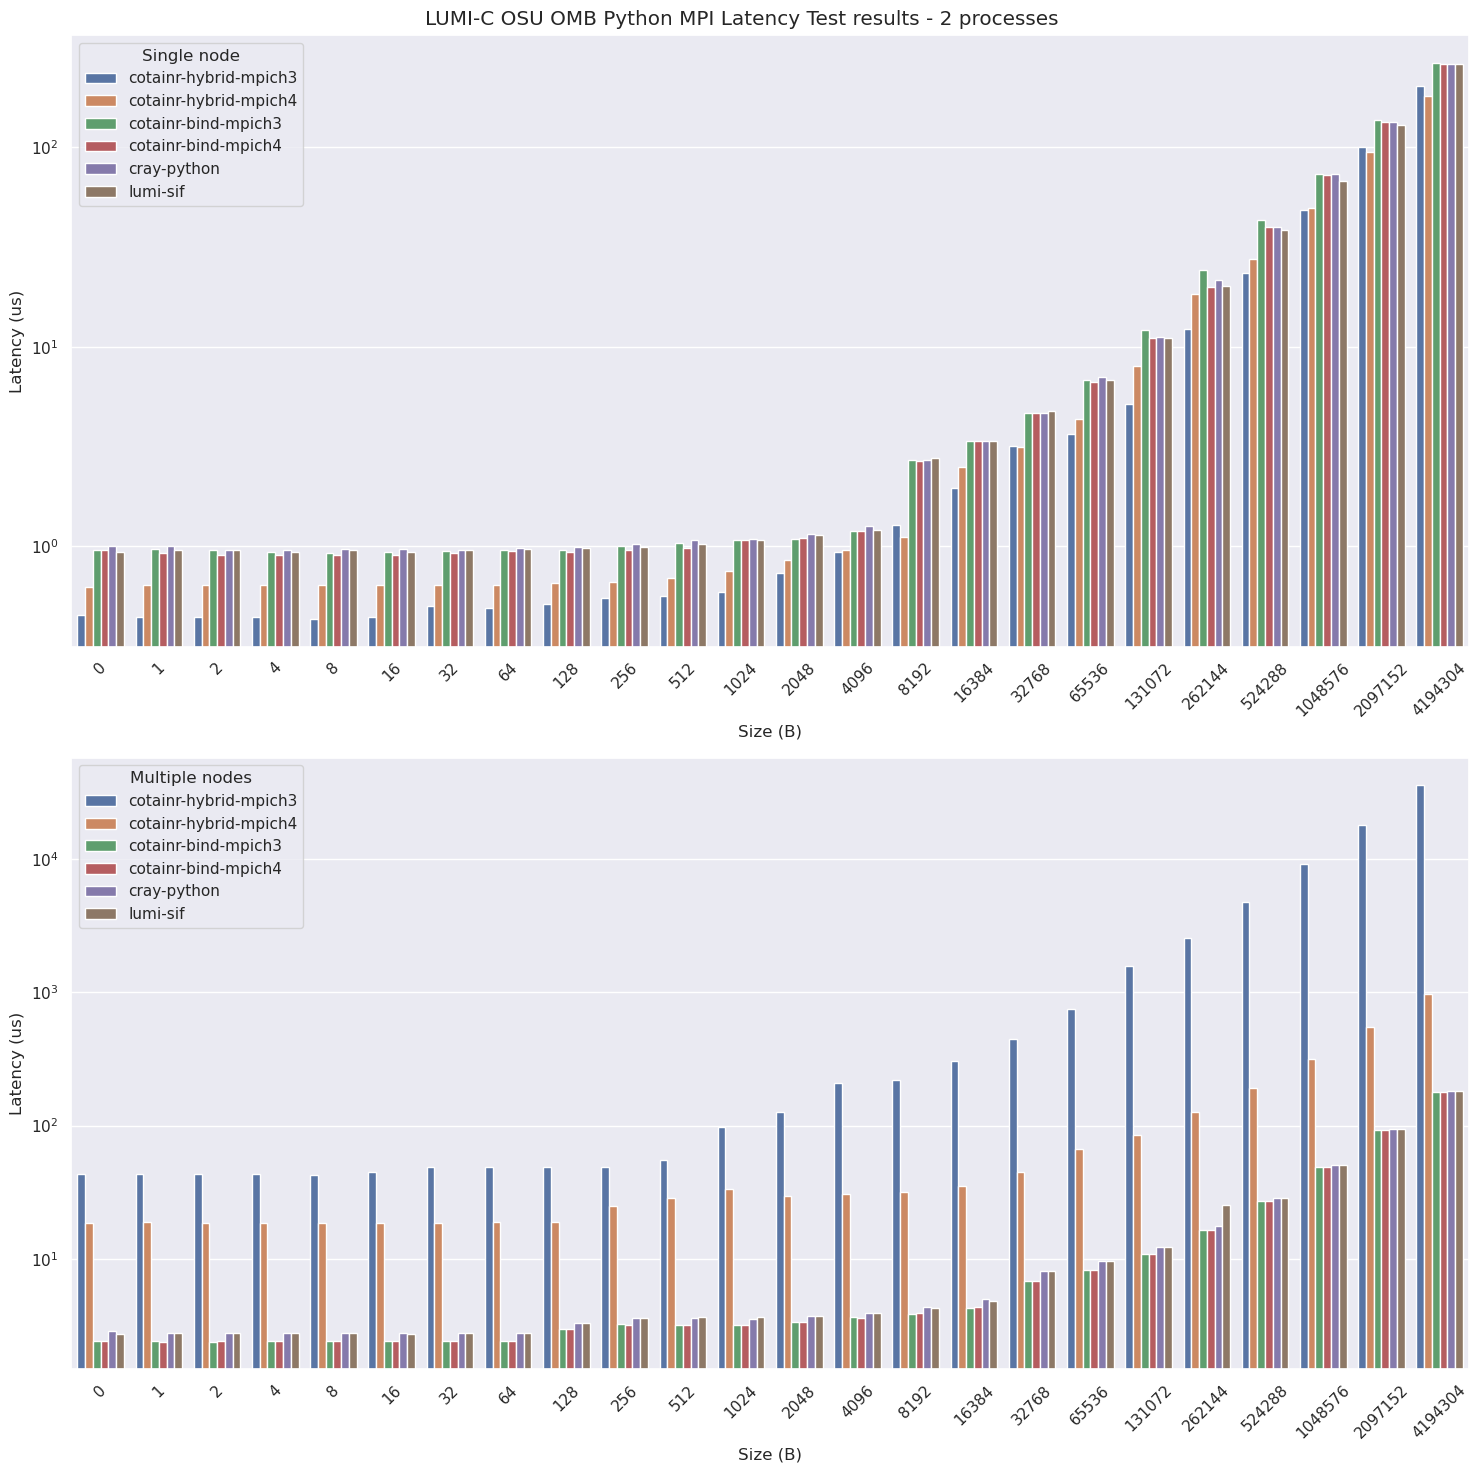

In [10]:
fig_latency = barplot_osu_results(
    df=osu_result_dfs["latency"],
    metric=tests["latency"]["metric"],
    processes=tests["latency"]["processes"],
    test_methods=test_methods,
)